In [1]:
import os
from jf import Mymaps
import matplotlib.pyplot as plt 
import numpy as np 
from astropy.wcs import WCS
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
import reproject as rp
from scipy import stats
from tqdm import trange
from astropy.coordinates import SkyCoord
from astropy.nddata.utils import Cutout2D
import astropy.units as u
from astropy.visualization.wcsaxes import SphericalCircle

with fits.open('./data2/galaxies_sorted.fits') as hdulist:
    plateifu_list = hdulist[1].data['plateifu']
    RAs = hdulist[1].data['RA']
    DECs = hdulist[1].data['DEC']
    
lofar_file_path = './data2/lofar_imgs/'
lofar_list = os.listdir(lofar_file_path)
lofar_list = np.sort(lofar_list)

import warnings 
warnings.filterwarnings("ignore")

[INFO]: No release version set. Setting default to DR15


In [2]:
def ptp_plot(n):
    gal = Mymaps(plateifu=plateifu_list[n], max_radii=10)
    with fits.open(lofar_file_path+lofar_list[n]) as hdulofar:
        lofarim = hdulofar[0].data
        lofar_header = hdulofar[0].header
    ha = gal.psf_m()
    lofarim_up, footprint = rp.reproject_exact((lofarim, WCS(lofar_header)), gal.wcs, shape_out=np.shape(ha))
    mean, med, sd = sigma_clipped_stats(lofarim)
    ha[lofarim_up<mean+3*sd] = np.nan
    lofarim_up[np.isnan(ha)] = np.nan
    fig = plt.figure()
    ax1 = plt.subplot(1,2,1,projection=gal.wcs)
    ax1.imshow(ha,origin='lower')
    ax1.contour(lofarim_up, colors='grey', levels=[mean+3*sd,mean+6*sd])
    ax2 = plt.subplot(1,2,2,projection=gal.wcs)
    ax2.imshow(lofarim_up,origin='lower')
    plt.show()
    c = stats.spearmanr(lofarim_up[~np.isnan(lofarim_up)],ha[~np.isnan(ha)])[0]
    fig = plt.figure()
    ax = plt.axes()
    ax.scatter(lofarim_up[~np.isnan(lofarim_up)],ha[~np.isnan(ha)])
    print(c)

def ptp(n):
    gal = Mymaps(plateifu=plateifu_list[n], max_radii=10)
    with fits.open(lofar_file_path+lofar_list[n]) as hdulofar:
        lofarim = hdulofar[0].data
        lofar_header = hdulofar[0].header
    ha = gal.psf_m()
    lofarim_up, footprint = rp.reproject_exact((lofarim, WCS(lofar_header)), gal.wcs, shape_out=np.shape(ha))
    mean, med, sd = sigma_clipped_stats(lofarim)
    ha[lofarim_up<mean+3*sd] = np.nan
    lofarim_up[np.isnan(ha)] = np.nan
    r = stats.spearmanr(lofarim_up[~np.isnan(lofarim_up)],ha[~np.isnan(ha)])[0]
    points = [lofarim_up[~np.isnan(lofarim_up)],ha[~np.isnan(ha)]]
    return r, points

def ptp_down(n):
    gal = Mymaps(plateifu=plateifu_list[n], max_radii=10)
    with fits.open(lofar_file_path+lofar_list[n]) as hdulofar:
        lofarim = hdulofar[0].data
        lofar_header = hdulofar[0].header
    ha = gal.psf_m()
    ha_down, footprint = rp.reproject_exact((ha, gal.wcs), lofar_header)
    mean, med, sd = sigma_clipped_stats(lofarim)
    ha_down[lofarim<mean+3*sd] = np.nan
    lofarim[np.isnan(ha_down)] = np.nan
    r = stats.spearmanr(lofarim[~np.isnan(lofarim)],ha_down[~np.isnan(ha_down)])[0]
    points = [lofarim[~np.isnan(lofarim)],ha_down[~np.isnan(ha_down)]]
    return r, points

100%|██████████| 6/6 [00:04<00:00,  1.29it/s]


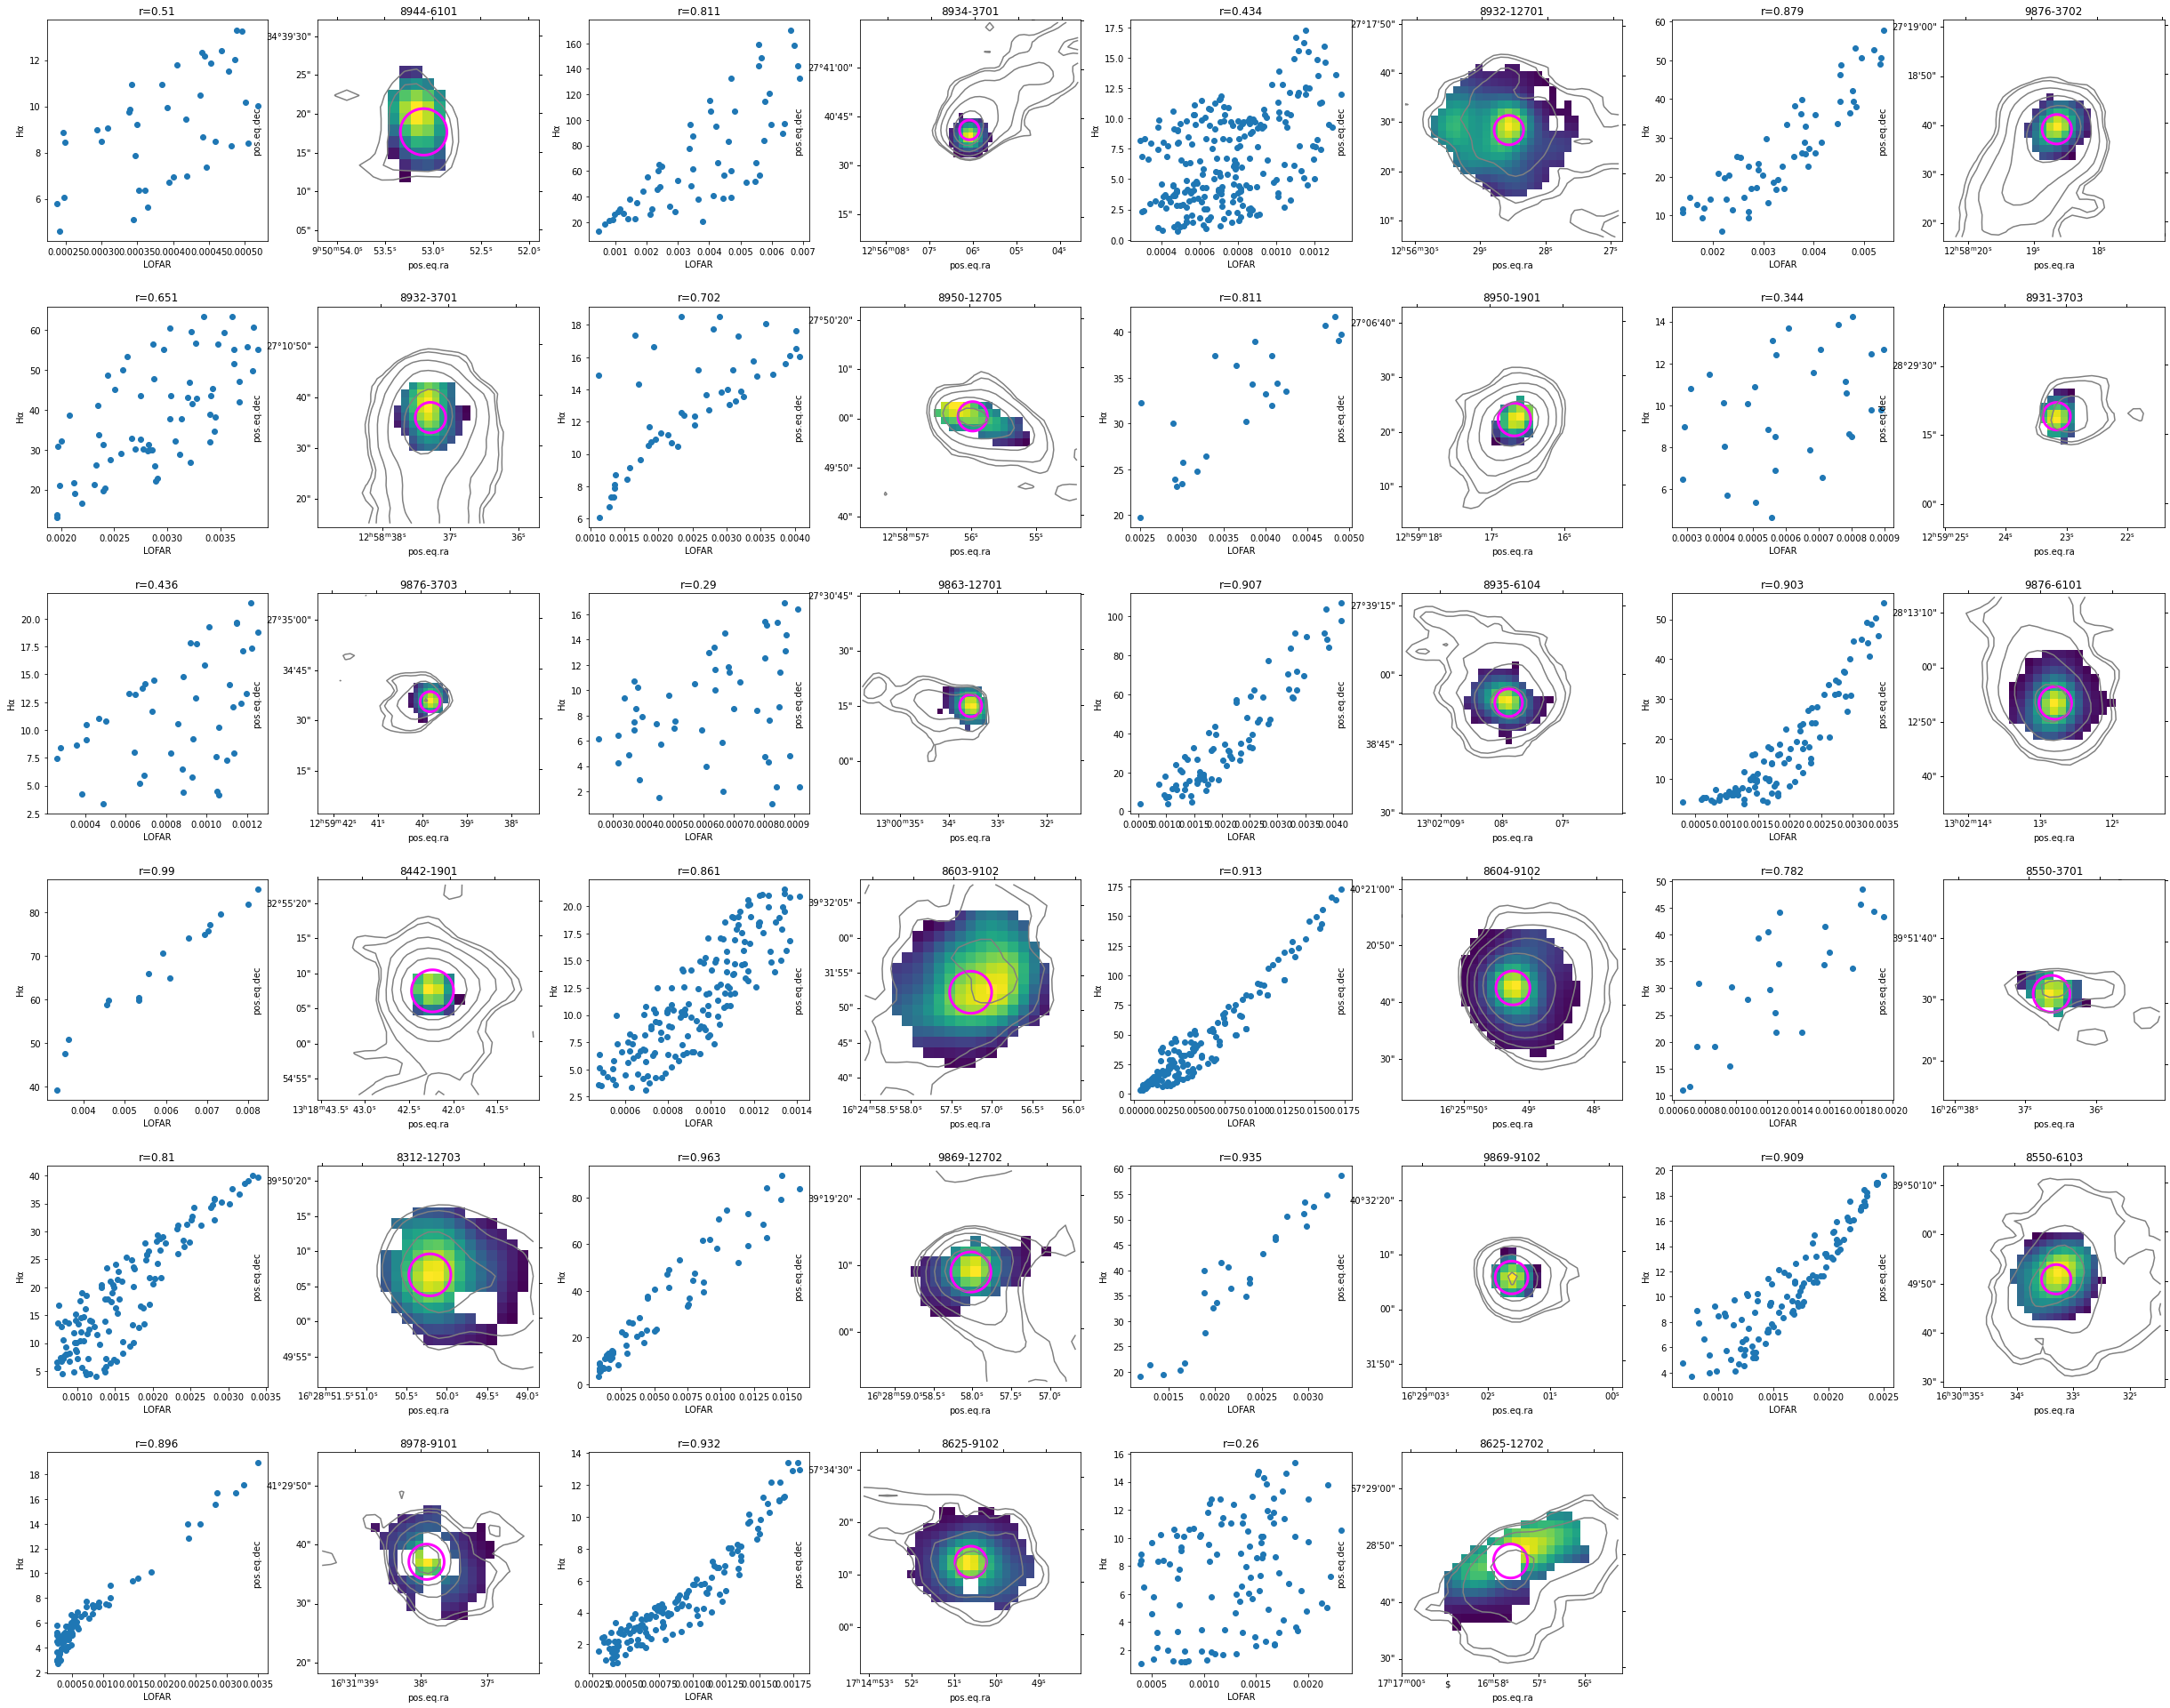

In [84]:
# fig, axs = plt.subplots(nrows=6, ncols=8, figsize=(34, 27))
row = 6
col = 4
plt.yticks(rotation=90)
for i in trange(row):
    for j in range(col):
        n = i*col+j
        if n<len(plateifu_list):
            gal = Mymaps(plateifu=plateifu_list[n], max_radii=10)
            with fits.open(lofar_file_path+lofar_list[n]) as hdulofar:
                lofarim = hdulofar[0].data
                lofar_header = hdulofar[0].header
            ha = gal.psf_m()
            ha_down, footprint = rp.reproject_exact((ha, gal.wcs), lofar_header)
            mean, med, sd = sigma_clipped_stats(lofarim)
            ha_down[lofarim<mean+3*sd] = np.nan
            lofar_im_copy = np.copy(lofarim)
            lofarim[np.isnan(ha_down)] = np.nan
            r = stats.spearmanr(lofarim[~np.isnan(lofarim)],ha_down[~np.isnan(ha_down)])[0]

            ax1 = plt.subplot(row, col*2, 2*n+1)
            ax1.scatter(lofarim[~np.isnan(lofarim)],ha_down[~np.isnan(ha_down)])
            ax1.set_xlabel('LOFAR')
            ax1.set_ylabel(r'$\mathrm{H\alpha}$')
            ax1.set_title('r='+str(round(r, 3) ))
            ax1.set_aspect(1.0/ax1.get_data_ratio(), adjustable='box')

            ra = RAs[n]
            dec = DECs[n]
            w_lofar = WCS(lofar_header)
            coord = SkyCoord(ra, dec, unit='deg', frame='icrs')
            cut_lofar = Cutout2D(lofar_im_copy, coord, 15/gal.ang_dis, wcs=w_lofar, mode='partial', fill_value=0)
            cut_ha = Cutout2D(ha_down, coord, 15/gal.ang_dis, wcs=w_lofar, mode='partial', fill_value=0)

            ax2 = plt.subplot(row, col*2, 2*n+2, projection=cut_lofar.wcs)
            ax2.imshow(cut_ha.data, origin='lower')
            ax2.contour(cut_lofar.data, colors='grey', levels = [mean+3*sd,mean+4*sd,mean+8*sd,mean+16*sd,mean+32*sd])
            ax2.margins(x=0, y=0)
            r = SphericalCircle((ra * u.deg, dec * u.deg), 3 * u.arcsec,
                     edgecolor='magenta', facecolor='none', lw=3,
                     transform=ax2.get_transform('icrs')
                     )
            ax2.add_patch(r)

            ax2.set_title(plateifu_list[n])

fig = plt.gcf()
fig.set_size_inches(34, 27)
plt.tight_layout()
# fig.savefig('ptp_jelly.pdf')

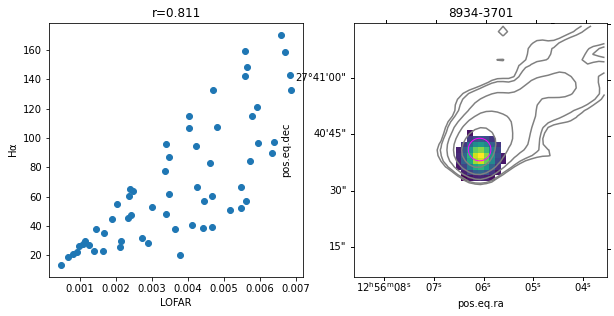

In [78]:
n = 1
gal = Mymaps(plateifu=plateifu_list[n], max_radii=10)
with fits.open(lofar_file_path+lofar_list[n]) as hdulofar:
    lofarim = hdulofar[0].data
    lofar_header = hdulofar[0].header
ha = gal.psf_m()
ha_down, footprint = rp.reproject_exact((ha, gal.wcs), lofar_header)
mean, med, sd = sigma_clipped_stats(lofarim)
ha_down[lofarim<mean+3*sd] = np.nan
lofar_im_copy = np.copy(lofarim)
lofarim[np.isnan(ha_down)] = np.nan
r = stats.spearmanr(lofarim[~np.isnan(lofarim)],ha_down[~np.isnan(ha_down)])[0]

ax1 = plt.subplot(121)
ax1.scatter(lofarim[~np.isnan(lofarim)],ha_down[~np.isnan(ha_down)])
ax1.set_xlabel('LOFAR')
ax1.set_ylabel(r'$\mathrm{H\alpha}$')
ax1.set_title('r='+str(round(r, 3) ))
ax1.set_aspect(1.0/ax1.get_data_ratio(), adjustable='box')

ra = RAs[n]
dec = DECs[n]
w_lofar = WCS(lofar_header)
coord = SkyCoord(ra, dec, unit='deg', frame='icrs')
cut_lofar = Cutout2D(lofar_im_copy, coord, 15/gal.ang_dis, wcs=w_lofar, mode='partial', fill_value=0)
# cut_lofar = Cutout2D(lofar_im_copy, coord, 30*u.arcsec, wcs=w_lofar, mode='partial', fill_value=0)
cut_ha = Cutout2D(ha_down, coord, 15/gal.ang_dis, wcs=w_lofar, mode='partial', fill_value=0)
# cut_ha = Cutout2D(ha_down, coord, 30*u.arcsec, wcs=w_lofar, mode='partial', fill_value=0)

ax2 = plt.subplot(122, projection=cut_lofar.wcs)
ax2.margins(x=0, y=0)
ax2.imshow(cut_ha.data, origin='lower')
ax2.contour(cut_lofar.data, colors='grey', levels = [mean+3*sd,mean+4*sd,mean+8*sd,mean+16*sd,mean+32*sd])

ax2.set_title(plateifu_list[n])

r = SphericalCircle((ra * u.deg, dec * u.deg), 3 * u.arcsec,
                     edgecolor='magenta', facecolor='none',
                     transform=ax2.get_transform('icrs')
                     )
# r = SphericalCircle((0.5, 0.5), 3 * u.arcsec,
#                      edgecolor='black', facecolor='none',
#                      transform=ax2.get_transform('icrs')
#                      )
ax2.add_patch(r)

fig = plt.gcf()
fig.set_size_inches(10,20)

In [15]:
n = 1
gal = Mymaps(plateifu=plateifu_list[n], max_radii=10)
with fits.open(lofar_file_path+lofar_list[n]) as hdulofar:
    lofarim = hdulofar[0].data
    lofar_header = hdulofar[0].header
w_lofar = WCS(lofar_header)

ax = plt.axes(projection=w_lofar)
ax.imshow

<WCSAxesSubplot:title={'center':'8934-3701'}, xlabel='pos.eq.ra', ylabel='pos.eq.dec'>